<a href="https://colab.research.google.com/github/mmonem1996/Simple_Dense_Neural_Network/blob/main/Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation Algorithm for Fully Connected Neural Network
The below code implement a simple algorithm for training a fully connected layers of a neural network via ***NeuralNetwork*** class.

The code moves then to apply this class in a simple classification task of idnetifying MNIST hand-written digits.




In [1]:
import cupy as np # using GPU CUDA features, substitute to numpy to use CPU
from urllib.request import urlretrieve
import gzip, json
from IPython.display import clear_output
from google.colab import drive
from shutil import copyfile
import sklearn.metrics as skm
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

In [2]:
from matplotlib import pyplot as plt 
%matplotlib inline

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Downloading Datasets

In [3]:
# downloading training datasets
training_images = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
training_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
urlretrieve(training_images, '/content/training_images.gz')
urlretrieve(training_labels, '/content/training_labels.gz')

('/content/training_labels.gz', <http.client.HTTPMessage at 0x7fc0c8484490>)

In [4]:
# unzipping training data
with gzip.open('/content/training_images.gz', 'rb') as zfile:
  with open('/content/train-images.idx3-ubyte', 'wb') as decompressed:
    decompressed.write(zfile.read())

with gzip.open('/content/training_labels.gz', 'rb') as zfile:
  with open('/content/train-labels.idx1-ubyte', 'wb') as decompressed:
    decompressed.write(zfile.read())

In [5]:
# downloading testing datasets
testing_images = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
testing_labels = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
urlretrieve(testing_images, '/content/testing_images.gz')
urlretrieve(testing_labels, '/content/testing_labels.gz')

('/content/testing_labels.gz', <http.client.HTTPMessage at 0x7fc0c847f4d0>)

In [6]:
# unzipping testing data
with gzip.open('/content/testing_images.gz', 'rb') as zfile:
  with open('/content/tk10-images.idx3-ubyte', 'wb') as decompressed:
    decompressed.write(zfile.read())

with gzip.open('/content/testing_labels.gz', 'rb') as zfile:
  with open('/content/tk10-labels.idx1-ubyte', 'wb') as decompressed:
    decompressed.write(zfile.read())

## Auxilary functions

In [7]:
# activation functions
def sigmoid_activation(z):
    sigma = 1 / (1 + np.exp(-z))
    dsigma = sigma * (1 - sigma)
    return sigma, dsigma


def relu_activation(z):
    zz = np.zeros(z.shape)
    zz[z > 0] = 1.0
    return z * zz, zz


def mse_loss(y, ypred):
    C = (y - ypred) @ (y - ypred).T / y.shape[1]
    return C.sum(), (-2 / y.shape[1]) * (y - ypred)

def log_loss(y, ypred):
    n = y.shape[1]
    C = (-1/n) * (y * np.log(ypred) + (1 - y) * np.log(np.ones_like(ypred) - ypred))
    J = (1/n) * (ypred - y)/(ypred * ( 1 - ypred ))
    return C.sum(), J

In [8]:
# the sturcture of idx3 file is discussed in http://yann.lecun.com/exdb/mnist/
def read_idx3_file_images(file: str):
  with open(file, 'rb') as idx_file:
    idx_file.read(4) # reading out the magic number
    num_of_images = int.from_bytes(idx_file.read(4), 'big')
    nrows = int.from_bytes(idx_file.read(4), 'big')
    ncols = int.from_bytes(idx_file.read(4), 'big')
    images = np.zeros((num_of_images, nrows * ncols), dtype=np.uint8)
    for i in range(num_of_images):
      imi_bytes = list(idx_file.read(nrows * ncols))
      imi = np.array(imi_bytes, dtype=np.uint8)
      images[i, :] = imi
  return images, nrows, ncols

In [9]:
# the sturcture of idx1 file is discussed in http://yann.lecun.com/exdb/mnist/
def read_idx1_file_labels(file: str):
  with open(file, 'rb') as idx_file:
    idx_file.read(8)
    labels = list(idx_file.read())
  return labels

## Model Training

In [10]:
class Perceptron:
    def __init__(self, input_layer_size, hidden_layers: tuple, output_layer, activation_function='sigmoid',
                 loss_function='mse', optimization='full-batch'):
        # Setting the optimization parameters
        self._hidden_layers =  hidden_layers
        self._optimization = optimization
        # Setting the neuron activation function
        self._activation = lambda z: (z, np.ones_like(z))
        if activation_function == 'sigmoid':
            self._activation = sigmoid_activation
        elif activation_function == 'relu':
            self._activation = sigmoid_activation
        # setting the loss function
        if loss_function == 'log-loss':
            self._loss = log_loss
        else: 
            self._loss = mse_loss
        # initializing random_weights
        layers = [input_layer_size]
        layers.extend(hidden_layers)
        layers.append(output_layer)
        self._weights = []

        for i in range(1, len(layers)):
            self._weights.append(np.random.uniform(-1, 1, (layers[i], layers[i - 1] + 1)))

    def fit(self, X, y, alpha=0, epochs = 100, learning_rate = 0.01):
        costs = self._gradient_descend(X, y, alpha, epochs, learning_rate)
        return costs

    def predict(self, X):
        return self._forward_pass(X).T

    def _forward_pass(self, X, y=None):
        ai = X.T
        dsigma = []
        gradients = []
        alist = [ai]
        for w in self._weights:
            ai = np.concatenate((np.ones((1, ai.shape[1])), ai), axis=0)
            # print(w.shape)
            # print(ai.shape)
            z = w @ ai
            ai, ds = self._activation(z)
            dsigma.append(ds)
            alist.append(ai)

        al = ai.copy()
        if y is None:
            return al
        yt = y.T
        C, J = self._loss(yt, ai)
        for i in range(len(self._weights) - 1, -1, -1):
            J = J * dsigma[i]
            ai = np.concatenate((np.ones((1, alist[i].shape[1])), alist[i]))
            # ai = alist[i]
            gradients.insert(0, J @ ai.T) # / alist[i].shape[1]
            J = self._weights[i].T @ J
            J = J[1:, :]

        return al, gradients, C

    def _gradient_descend(self, X, y, alpha=0, epochs = 100, learning_rate = 0.01, update_frequency = 10):
        if self._optimization == 'full-batch':
            costs = []
            for i in range(epochs):
                _, grads, C = self._forward_pass(X, y)
                if (i+1) % update_frequency == 0:
                    clear_output(True)
                    print('Iteration %d:\tCost = %0.4f' % ((i + 1), C))
                costs.append(C)
                for j in range(len(self._weights)):
                    self._weights[j] = self._weights[j] - learning_rate * grads[j]
                    if alpha != 0:
                        penaltyw = self._weights[j]
                        penaltyw[:, 0] = 0
                        self._weights[j] -= penaltyw * alpha
                
        elif self._optimization == 'stochastic':
            pass
        return costs

    def get_serialized_filename(self):
        fmt = '{0}layers_NN_'
        nHUlayers = len(self._hidden_layers)
        for i in range(1, nHUlayers):
            fmt += '{' + f'1[{i}]' + '}_'
        fmt += 'HU_' + self._activation.__name__ + '_activation.json'
        return fmt.format(nHUlayers, self._hidden_layers)

    def serialize(self, filename=None):
        # Once suitable parameters are reached, it is possible to use this
        # function to save them in json file
        if filename is None:
            filename = self.get_serialized_filename()
        with open(filename, 'w') as param_file:
            ser_layer_list = []
            for wi in self._weights:
              wi = wi.tolist()
              ser_layer_list.append(wi)
            json.dump(ser_layer_list, param_file, indent=2)
      

    def load_serialized(self, filename=None):
      # load saved json file
      self._weights = []
      if filename is None:
          filename = self.get_serialized_filename()
      with open(filename, 'r') as param_file:
          ser_layer_list = json.load(param_file)
          self._weights = []
          for wi in ser_layer_list:
              wi = np.array(wi)
              self._weights.append(wi)

In [11]:
images, r, c = read_idx3_file_images('/content/train-images.idx3-ubyte')
labels = read_idx1_file_labels('/content/train-labels.idx1-ubyte')

In [13]:
print(len(labels_sampled))

10000


In [66]:
# modify size_of_dataset as suitable to hardware, max value is 60000
size_of_dataset = 5000
sss = StratifiedShuffleSplit(1, test_size=(size_of_dataset / 60000))
_, sampled_indices =  next(sss.split(images, labels))
x = np.asarray(images.T[:,sampled_indices], dtype=float)
labels_sampled = np.array(labels)[sampled_indices]
x = x / 255
y = np.zeros((10, x.shape[1]))
for i in range(x.shape[1]):
  y[labels_sampled[i], i] = 1.0
# del images

In [67]:

# print((np.min(x), np.max(x)))
# x = (x - np.mean(x, axis=0, keepdims=True))/np.std(x, axis=0, keepdims=True)
nn = Perceptron(28 * 28, (300, 300), 10, loss_function='log-loss', activation_function='relu')

In [68]:
costs = nn.fit(x.T, y.T, epochs=10000, learning_rate=0.01)

Iteration 10000:	Cost = 0.5204


Text(0.5, 1.0, 'Cost vs Iterations')

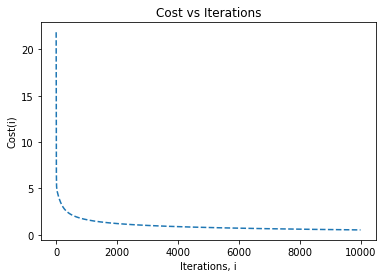

In [69]:
plt.plot(np.arange(1, len(costs) + 1).tolist(), costs, '--')
plt.xlabel('Iterations, i')
plt.ylabel('Cost(i)')
plt.title('Cost vs Iterations')

In [70]:
test_index = 10
o0 = nn.predict(x[:, test_index].reshape(1,-1))
print(np.round_(o0, 4).flatten())
print(np.round_(y[:, test_index], 4))

[4.000e-04 1.000e-04 3.400e-03 9.946e-01 1.400e-03 1.200e-03 4.600e-03
 2.000e-03 9.700e-03 1.000e-04]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [71]:
al = nn.predict(x.T)
y_pred = np.argmax(al, axis=1).flatten()
y_true = np.array(labels_sampled)
score = skm.accuracy_score(y_pred.tolist(), y_true.tolist())
print('Accuracy score: {:.2f}%'.format(100*score))

Accuracy score: 94.12%


In [38]:
np.max(y_pred)

array(9)

---
## Loading/Unloading NN parameters
The below cells are for loading. modify it to load from your drive or to directly load from the mounted space without using google.drive module.

In [ ]:
src = '/content/gdrive/My Drive/Colab Notebooks/neural_networks/' + nn.get_serialized_filename()
dst = '/content/' + nn.get_serialized_filename()
copyfile(src, dst)
nn.load_serialized()

In [ ]:
nn.serialize()
dst = '/content/gdrive/My Drive/Colab Notebooks/neural_networks/' + nn.get_serialized_filename()
src = '/content/' + nn.get_serialized_filename()
copyfile(src, dst)

'/content/gdrive/My Drive/Colab Notebooks/neural_networks/3layers_NN_500_150_HU_logistic_activation.json'

---
## Model Testing

In [72]:
images_test, r, c = read_idx3_file_images('/content/tk10-images.idx3-ubyte')
labels_test = read_idx1_file_labels('/content/tk10-labels.idx1-ubyte')

In [73]:
# modify size_of_dataset as suitable to hardware, max value is 60000
xtest = np.asarray(images_test.T[:,:], dtype=np.float)
xtest = xtest / 255
ytest = np.zeros((10, len(labels_test)))
for i in range(len(labels_test)):
  ytest[labels_test[i], i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `cupy.float` is a deprecated alias for the Python scalar type `float`. Please use the builtin `float` or its corresponding NumPy scalar type `cupy.float_` instead.
  


In [74]:
al = nn.predict(xtest.T)
y_pred = np.argmax(al, axis=1).flatten()
y_true = np.array(labels_test)
score = skm.accuracy_score(y_pred.tolist(), y_true.tolist())
print('Accuracy score: {:.2f}%'.format(100*score))

Accuracy score: 88.22%


### Sample image testing

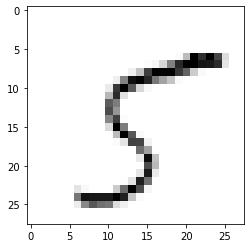

In [75]:
# acquire a random image from the testing set
sample_image = images_test[np.random.randint(0, len(labels_test)), :].reshape(-1, 1)
plt.imshow(np.asnumpy(sample_image.reshape(28, 28)), cmap='Greys')

In [76]:
# test the network classifier on the sample image
sample_image = sample_image/255 # mapping to (0, 1) range
predicted_values = nn.predict(sample_image.T).flatten()
indices = np.argsort(predicted_values)[::-1]
results = np.vstack((indices, np.round_(predicted_values[indices], 3))).T
pv = pd.DataFrame(results, columns=['Recognized Digit', 'Confidence Score'])
pv['Recognized Digit'] = pv['Recognized Digit'].apply(lambda d: int(d))
pv.head()

,Recognized Digit,Confidence Score
0,5,0.977
1,7,0.035
2,9,0.006
3,1,0.002
4,8,0.001


In [ ]:
drive.flush_and_unmount()

---